In [2]:
from loguru import logger
import scimap as sm
import pandas as pd
import anndata as ad
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
import utils
import importlib
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

Running SCIMAP  2.1.3


In [3]:
import warnings
warnings.filterwarnings("ignore", category=ad._core.aligned_df.ImplicitModificationWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [4]:
logger.remove()
logger.add(sys.stdout, format="<green>{time:HH:mm:ss.SS}</green> | <level>{level}</level> | {message}")

1

In [5]:
adata = utils.read_quant("../data/quantification/993_backsub_quantification.csv")
gates = utils.read_gates("../data/phenotyping/20240905_993_gates.csv")
adata = utils.filter_adata_by_gates(adata, gates)
gates_993 = utils.process_gates_for_sm(gates, sample_id="993")

13:57:49.53 | INFO |  ---- read_quant : version number 1.0.0 ----
13:57:53.27 | INFO |  304243 cells and 75 variables
13:57:53.27 | INFO |  ---- read_quant is done, took 3s  ----
13:57:53.27 | INFO |  ---- read_gates : version number 1.0.0 ----
13:57:53.28 | INFO |    Filtering out all rows with value 0.0 (assuming not gated)
13:57:53.29 | INFO |   Found 8 valid gates
13:57:53.29 | INFO |  ---- read_gates is done, took 0s  ----
13:57:53.29 | INFO |  ---- filter_adata_by_gates : version number 1.0.0 ----
13:57:53.33 | INFO |  ---- filter_adata_by_gates is done, took 0s  ----
13:57:53.33 | INFO |  ---- process_gates_for_sm : version number 1.0.0 ----
13:57:53.33 | INFO |  ---- process_gates_for_sm is done, took 0s  ----


In [6]:
adata.raw = adata
adata = sm.pp.log1p(adata)
adata.obs['imageid'] = "993"

# Visualize unfiltered data

## Correlation of marker mean intensity values between cells

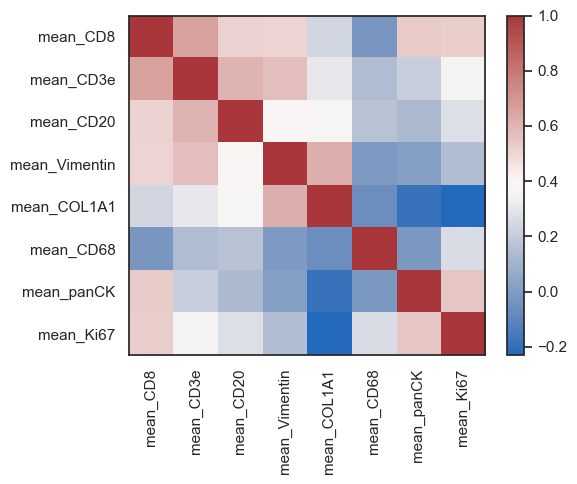

In [7]:
sm.pl.markerCorrelation(adata, figsize=(6,5))

Comments:   
1. Both Ki67 and PanCK overlap little with COL1A1. COL1A1 has little growth, and PanCk should not be in structural tissue.
2. Immune cells have a higher degree of correlation
3. Cancer and CD8 have the highest Ki67 marker abundance.

# Filter out cells

### Cells with not enough DAPI

First, let us describe the distribution of cell DAPI intensities

In [9]:
df = pd.read_csv("../data/quantification/993_backsub_quantification.csv")
df = df.sample(frac=0.1, random_state=0).reset_index(drop=True) # use 10% of the data

<Axes: xlabel='X_centroid', ylabel='Y_centroid'>

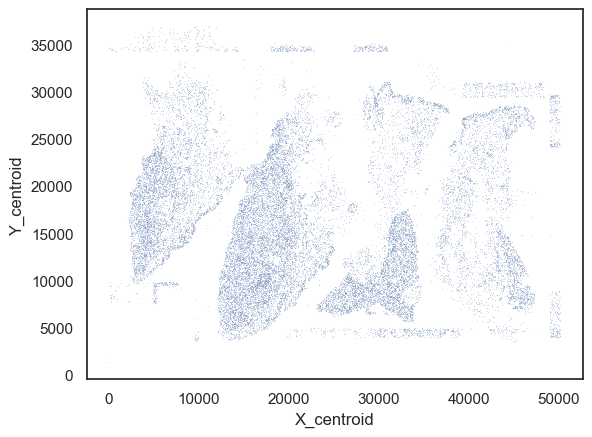

In [10]:
# check positions of cells
sns.scatterplot(data=df, x="X_centroid", y="Y_centroid", alpha=0.3, s=0.6)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log10

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

invalid value encountered in log10



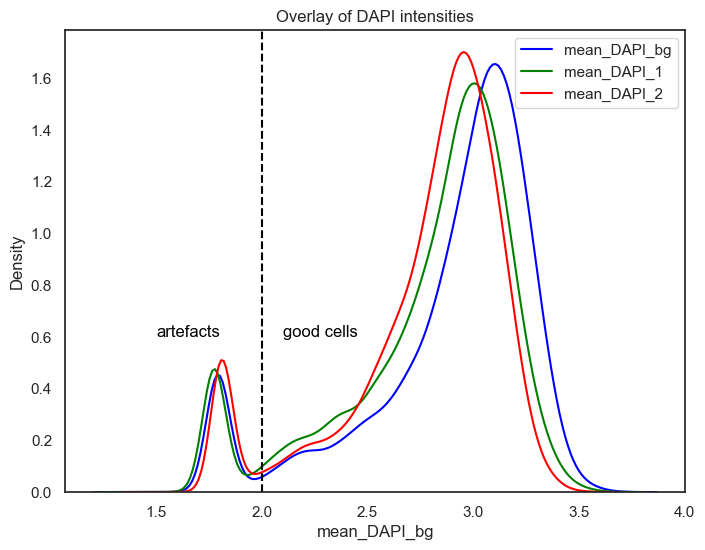

In [17]:
# Plot the density plot for each column
plt.figure(figsize=(8,6))
tmp_df = np.log10(df)
sns.kdeplot(tmp_df['mean_DAPI_bg'], label='mean_DAPI_bg', color='blue')
sns.kdeplot(tmp_df['mean_DAPI_1'], label='mean_DAPI_1', color='green')
sns.kdeplot(tmp_df['mean_DAPI_2'], label='mean_DAPI_2', color='red')

#add line in the end of first binomial peak
plt.axvline(2, color='black', linestyle='--')
# add text that labels line, on the right side as "good cells" and the left side as "artefacts"
plt.text(2.1, 0.6, 'good cells', fontsize=12, color='black')
plt.text(1.5, 0.6, 'artefacts', fontsize=12, color='black')

plt.title('Overlay of DAPI intensities')
plt.legend()
plt.show()

That hump in the beginning is all artefacts,
will remove everything less than DAPI 100 (in log10 space 2)

In [18]:
df = df[df['mean_DAPI_bg'] > 100]

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log10

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

invalid value encountered in log10



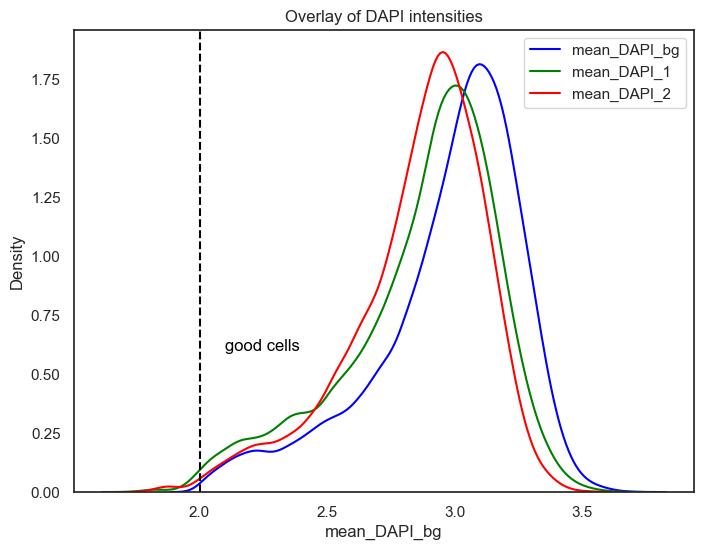

In [20]:
# Plot the density plot for each column
plt.figure(figsize=(8,6))
tmp_df = np.log10(df)
sns.kdeplot(tmp_df['mean_DAPI_bg'], label='mean_DAPI_bg', color='blue')
sns.kdeplot(tmp_df['mean_DAPI_1'], label='mean_DAPI_1', color='green')
sns.kdeplot(tmp_df['mean_DAPI_2'], label='mean_DAPI_2', color='red')

#add line in the end of first binomial peak
plt.axvline(2, color='black', linestyle='--')
# add text that labels line, on the right side as "good cells" and the left side as "artefacts"
plt.text(2.1, 0.6, 'good cells', fontsize=12, color='black')

plt.title('Overlay of DAPI intensities')
plt.legend()
plt.show()

Let's check the DAPI ratio between last cycle and first cycle 

In [40]:
df['DAPI_ratio'] = np.log10(df['mean_DAPI_bg'] / df['mean_DAPI_2'])

In [82]:
df['DAPI_ratio'] = df['mean_DAPI_2'] / df['mean_DAPI_bg']

In [73]:
#example 1: cell that lost half its intensity of DAPI
print(f" np.log10(100/50) = {round(np.log10(100/50),3)}")
# example 2: cell that lost 95% of their signal
print(f" np.log10(100/5) = {round(np.log10(100/5),3)}")
# example 3: cell that lost 75% of their signal
print(f" np.log10(100/25) = {round(np.log10(100/25),3)}")

#example 4: 'cell' that doubled their signal
print(f" np.log10(100/200) = {round(np.log10(100/200),3)}")

 np.log10(100/50) = 0.301
 np.log10(100/5) = 1.301
 np.log10(100/25) = 0.602
 np.log10(100/200) = -0.301


In [53]:
df['DAPI_ratio'].describe()

count    28301.000000
mean         0.119500
std          0.103572
min         -0.766508
25%          0.078441
50%          0.124498
75%          0.163032
max          1.487538
Name: DAPI_ratio, dtype: float64

In [77]:
np.log10(100/75)

0.12493873660829993

In [143]:
def filter_by_ratio(df, end_cycle, start_cycle, label="DAPI", min_ratio=0.5, max_ratio=1.05):

    df[f'{label}_ratio'] = df[end_cycle] / df[start_cycle]
    df[f'{label}_ratio_pass'] = (df[f'{label}_ratio'] > min_ratio) & (df[f'{label}_ratio'] < max_ratio)

    # print out statistics
    print(f"Number of cells with {label} ratio < {min_ratio}: {sum(df[f'{label}_ratio'] < min_ratio)}")
    print(f"Number of cells with {label} ratio > {max_ratio}: {sum(df[f'{label}_ratio'] > max_ratio)}")
    print(f"Number of cells with {label} ratio between {min_ratio} and {max_ratio}: {sum(df[f'{label}_ratio_pass'])}")
    #percentage filtered out
    print(f"Percentage of cells filtered out: {round(100 - sum(df[f'{label}_ratio_pass'])/len(df)*100,2)}%")

    # plot histogram

    sns.histplot(df[f'{label}_ratio'], color='blue')
    plt.yscale('log')

    plt.axvline(min_ratio, color='black', linestyle='--', alpha=0.5)
    plt.axvline(max_ratio, color='black', linestyle='--', alpha=0.5)
    plt.text(max_ratio + 0.05, 650, f"gained >{int(max_ratio*100-100)}% {label}", fontsize=9, color='black')
    plt.text(min_ratio - 0.05, 650, f"lost >{int(min_ratio*100-100)}% {label}", fontsize=9, color='black', horizontalalignment='right')

    plt.ylabel('cell count')
    plt.xlabel(f'{label} ratio (last/cycle)')
    plt.xlim(min_ratio-1, max_ratio+1)
    plt.show()

    return df

Number of cells with DAPI ratio < 0.25: 132
Number of cells with DAPI ratio > 1.25: 633
Number of cells with DAPI ratio between 0.25 and 1.25: 27536
Percentage of cells filtered out: 2.7%


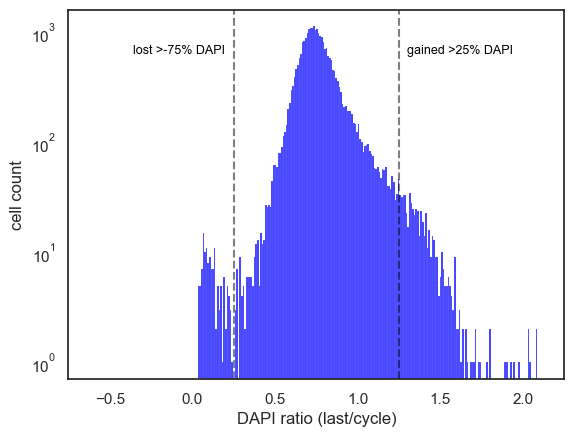

In [144]:
df = filter_by_ratio(df=df, end_cycle='mean_DAPI_2', start_cycle='mean_DAPI_bg', label="DAPI", min_ratio=0.25, max_ratio=1.25)

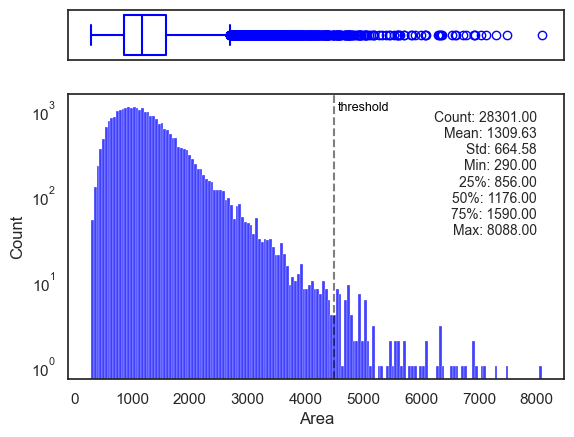

In [187]:
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data=df, x="Area", orient="h", ax=ax_box, fill=False, color='blue')
sns.histplot(data=df, x="Area", ax=ax_hist, color='blue')

plt.yscale('log')


desc_stats = df['Area'].describe()
textstr = '\n'.join((
    f'Count: {desc_stats["count"]:.2f}',
    f'Mean: {desc_stats["mean"]:.2f}',
    f'Std: {desc_stats["std"]:.2f}',
    f'Min: {desc_stats["min"]:.2f}',
    f'25%: {desc_stats["25%"]:.2f}',
    f'50%: {desc_stats["50%"]:.2f}',
    f'75%: {desc_stats["75%"]:.2f}',
    f'Max: {desc_stats["max"]:.2f}'
))

# Add the text box in the upper right corner
plt.gca().text(8000, 1000, textstr, fontsize=10, 
            verticalalignment='top', horizontalalignment='right')

ax_hist.axvline(4500, color='black', linestyle='--', alpha=0.5)
ax_hist.text(4550, 1000, 'threshold', fontsize=9, color='black')

ax_box.set(xlabel='')
plt.show()